# > **ODE:**
$$\frac{d^2 x}{d t^2}+\mu\frac{d x}{d t}+kx=0 $$

,where $ \mu=2m\delta, k = m\omega^2$

Condition: $x(0)=1, \frac{d x}{d t}(0)=0, m=1$


# > **Solution**
$$x(t)=2A e^{-\delta t} cos(\phi + \omega t)$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

USE_GPU = True
dtype = torch.float64

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


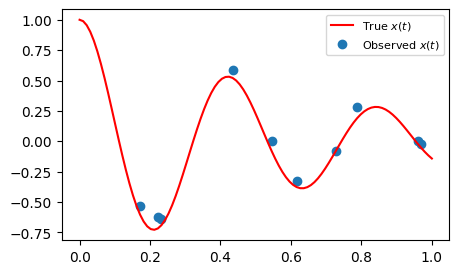

In [15]:
# https://beltoforion.de/en/harmonic_oscillator/
def oscillator(delta, omega0, t):
    assert delta < omega0
    omega   = np.sqrt(omega0**2 - delta**2)
    phi     = np.arctan(-delta/omega)
    A       = 1/(2*np.cos(phi))
    return torch.exp(-delta * t)*2*A*torch.cos(phi+omega*t)

N_grid, delta, omega0 =100, 1.5, 15
mu_real, k_real = 2*delta, omega0**2        ## mass = 1

t_grid  = torch.linspace(0, 1, N_grid).view(-1,1)
x_grid  = oscillator(delta, omega0, t_grid).view(-1,1)

N_obs = 10
idx     = np.random.choice(np.arange(len(t_grid)), replace=0, size=N_obs)
t_obs   = t_grid[idx]
x_obs   = x_grid[idx]

NOISE = True
if NOISE:
    x_obs += torch.rand(x_obs.size())*0.1

figure = plt.figure(figsize=(5,3))
plt.plot(t_grid, x_grid, color='r', label='True $x(t)$')
plt.scatter(t_obs, x_obs, marker='o',label='Observed $x(t)$')
plt.legend(fontsize=8)

t_obs, x_obs             = t_obs.to(device).requires_grad_(True), x_obs.to(device)
t_grid, x_grid           = t_grid.to(device).requires_grad_(True), x_grid.to(device)
t_init, x_init, dx_init  = torch.zeros([1,1]).to(device).requires_grad_(True), torch.ones([1,1]).to(device), torch.zeros([1,1]).to(device)

k   = torch.ones(1).to(device).requires_grad_(True)
mu  = torch.ones(1).to(device).requires_grad_(True)

In [16]:
model = nn.Sequential(nn.Linear(1,64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 1))
model = model.to(device)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': k, 'lr':0.01}, {'params': mu, 'lr':0.5}], lr=0.001)

scheduler = None
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20000], gamma=2)

In [6]:
def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True, grad_outputs=torch.ones(y.size()).to(device))[0]

In [ ]:
a = torch.linspace(-15, 15, 30)
print(a*2)

tensor([-30.0000, -27.9310, -25.8621, -23.7931, -21.7241, -19.6552, -17.5862,
        -15.5172, -13.4483, -11.3793,  -9.3103,  -7.2414,  -5.1724,  -3.1034,
         -1.0345,   1.0345,   3.1034,   5.1724,   7.2414,   9.3103,  11.3793,
         13.4483,  15.5172,  17.5862,  19.6552,  21.7241,  23.7931,  25.8621,
         27.9310,  30.0000])


In [17]:
history_loss, history_k, history_mu = [], [], []
history_MSE_real, history_MSE_obs = [], []

best_model=None
best_k, best_mu, best_loss = 0, 0, 100

# Train
model.train()

EPOCHS = 50000
weights = torch.sigmoid(torch.linspace(-15, 15, EPOCHS))*0.01
weights = weights.to(device)

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()

    output      = model(t_grid)                         # x(t)
    output_init = model(t_init)                         # x(t_init)
    output_obs  = model(t_obs)                          # x(t_obs)

    doutput     = derivative(output, t_grid)            # dx/dt(t)
    d2output    = derivative(doutput, t_grid)           # dx/dt(t)
    doutput_init= derivative(output_init, t_init)       # dx/dt(t_init)

    # # For general case, use below.
    # loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init) / 2                  # Loss for initial conditions
    # loss_obs    = loss_f(output_obs, x_obs) / N_obs                                                # Loss for observed data
    # loss_ge     = loss_f(d2output + mu*doutput + k*output, torch.zeros_like(doutput)) / N_grid     # Loss for ODE

    ## Original version. Not good for noisy case
    # loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init)                      # Loss for initial conditions
    # loss_obs    = loss_f(output_obs, x_obs)                                                        # Loss for observed data
    # loss_ge     = loss_f(d2output + mu*doutput + k*output, torch.zeros_like(doutput))*(1.0e-4)     # Loss for ODE

    # Importance of ODS loss will be increase as epochs proceeds (For noisy case)
    loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init)                         # Loss for initial conditions
    loss_obs    = loss_f(output_obs, x_obs)                                                           # Loss for observed data
    loss_ge     = loss_f(d2output + mu*doutput + k*output, torch.zeros_like(doutput))*weights[i-1]   # Loss for ODE

    loss        = loss_init + loss_obs + loss_ge
    loss.backward()

    optimizer.step()
    if scheduler != None:
        scheduler.step()

    history_loss.append(loss.item())
    history_mu.append(mu.item())
    history_k.append(k.item())
    history_MSE_real.append(loss_f(x_grid, model(t_grid)).item())
    history_MSE_obs.append(loss_f(x_obs, model(t_obs)).item())

    if loss.item() < best_loss:
        best_model = model
        best_loss, best_mu, best_k = loss.item(), mu.item(), k.item()

    # if not i % 1000 :
    #     print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_init : %8.7f | Loss_obs : %8.7f | mu : %.3f | k : %.3f'\
    #           %(i, EPOCHS, loss_ge.item(), loss_init.item(), loss_obs.item(), mu.item(), k.item()))

    if not i % 1000 :
        print('EPOCH : %6d/%6d | MSE_real : %8.7f | MSE_obs : %8.7f | mu : %.3f | k : %.3f'\
              %(i, EPOCHS,  history_MSE_real[-1], history_MSE_obs[-1], mu.item(), k.item()))

print('Training Finished.')

EPOCH :   1000/ 50000 | MSE_real : 0.0684666 | MSE_obs : 0.0597724 | mu : 0.302 | k : 13.268
EPOCH :   2000/ 50000 | MSE_real : 0.0514922 | MSE_obs : 0.0181230 | mu : 0.327 | k : 27.899
EPOCH :   3000/ 50000 | MSE_real : 0.0240250 | MSE_obs : 0.0114686 | mu : 0.628 | k : 42.434
EPOCH :   4000/ 50000 | MSE_real : 0.0179163 | MSE_obs : 0.0000975 | mu : 0.652 | k : 56.400
EPOCH :   5000/ 50000 | MSE_real : 0.0133203 | MSE_obs : 0.0000737 | mu : 0.814 | k : 70.415
EPOCH :   6000/ 50000 | MSE_real : 0.0107982 | MSE_obs : 0.0000744 | mu : 0.965 | k : 84.401
EPOCH :   7000/ 50000 | MSE_real : 0.0120303 | MSE_obs : 0.0001227 | mu : 1.083 | k : 98.252
EPOCH :   8000/ 50000 | MSE_real : 0.0089005 | MSE_obs : 0.0001278 | mu : 1.279 | k : 111.952
EPOCH :   9000/ 50000 | MSE_real : 0.0119710 | MSE_obs : 0.0020249 | mu : 1.312 | k : 125.409
EPOCH :  10000/ 50000 | MSE_real : 0.0233776 | MSE_obs : 0.0038183 | mu : 1.601 | k : 138.849
EPOCH :  11000/ 50000 | MSE_real : 0.0053270 | MSE_obs : 0.0002198 

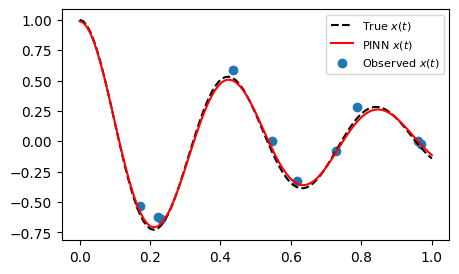

In [18]:
# View data
figure = plt.figure(figsize=(5,3))
plt.plot(t_grid.cpu().detach(), x_grid.cpu().detach(), color='k', linestyle='--', label='True $x(t)$')
# plt.plot(t_grid.cpu().detach(), best_model(t_grid).cpu().detach(), color='r', label='PINN $x(t)$') # For best model
plt.plot(t_grid.cpu().detach(), model(t_grid).cpu().detach(), color='r', label='PINN $x(t)$')        # For final model
plt.scatter(t_obs.cpu().detach(), x_obs.cpu().detach(), marker='o',label='Observed $x(t)$')
plt.legend(fontsize=8)

plt.savefig('x_vs_t.png', dpi=300)

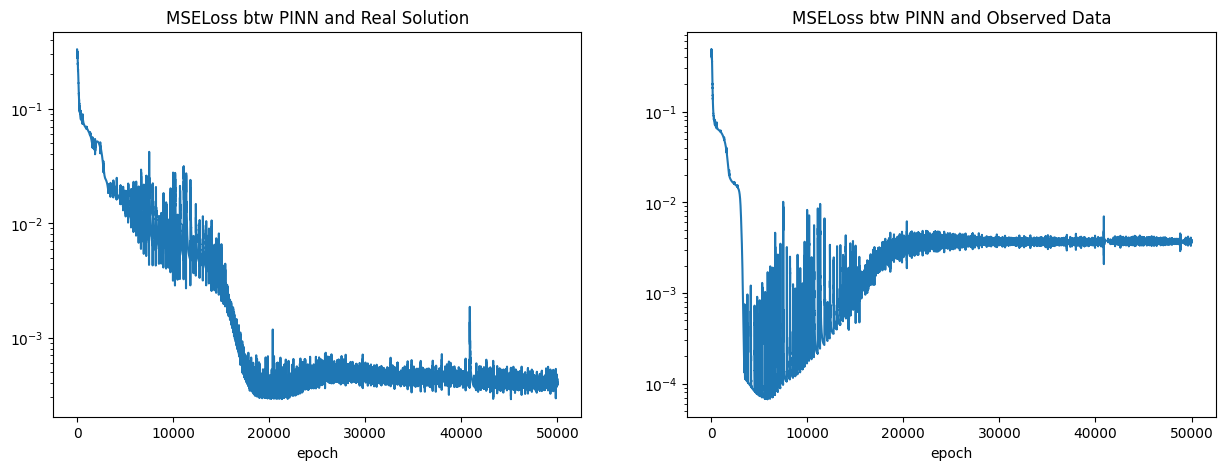

In [21]:
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,2,1)
ax1.set_yscale('log')
ax1.plot(history_MSE_real)
ax1.set_title('MSELoss btw PINN and Real Solution')
ax1.set_xlabel('epoch')

ax2 = figure.add_subplot(1,2,2)
ax2.set_yscale('log')
ax2.plot(history_MSE_obs)
ax2.set_title('MSELoss btw PINN and Observed Data')
ax2.set_xlabel('epoch')

plt.savefig('MSE_loss.png', dpi=300)

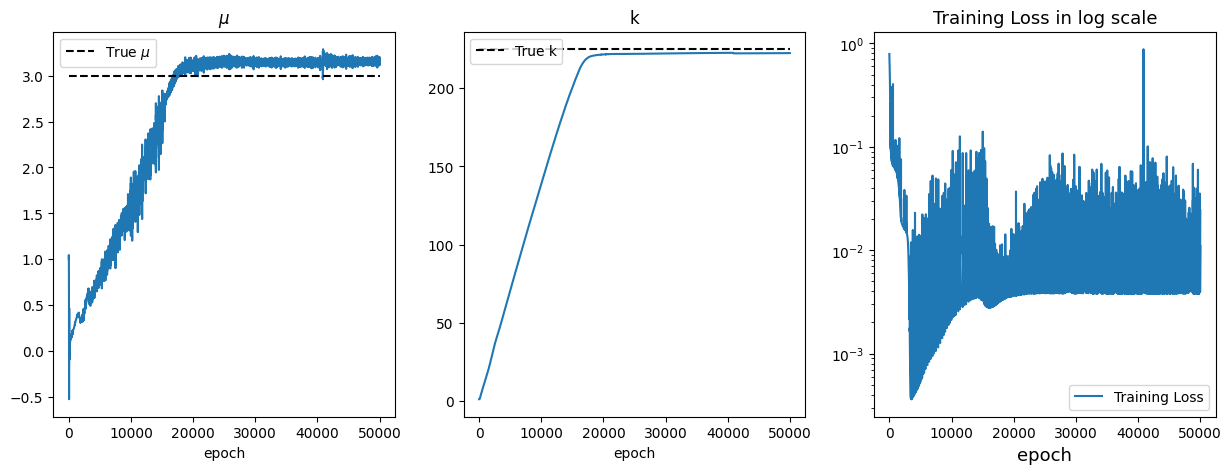

In [20]:
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(history_mu)
ax1.set_title('$\mu$')
ax1.set_xlabel('epoch')
ax1.hlines(mu_real, 0, EPOCHS, color='k',linestyle='--', label='True $\mu$')
# ax1.hlines(best_mu, 0, EPOCHS, color='r', label='Best $\mu$') # For best model
ax1.legend()


ax2 = figure.add_subplot(1,3,2)
ax2.plot(history_k)
ax2.set_title('k')
ax2.set_xlabel('epoch')
ax2.hlines(k_real, 0, EPOCHS, color='k', linestyle='--', label='True k')
# ax2.hlines(best_k, 0, EPOCHS, color='r', label='Best k') # For best model
ax2.legend()


ax3 = figure.add_subplot(1,3,3)
ax3.plot(history_loss, label='Training Loss')
ax3.set_yscale('log')
ax3.legend()
ax3.set_title('Training Loss in log scale', fontsize=13)
ax3.set_xlabel('epoch', fontsize=13)

plt.savefig('mu_k_loss.png', dpi=300)